Introducción

Aqui econ al eva_3 nuestro trabajo tiene el objetivo implementar un modelo Autoencoder utilizando el conjunto de datos Fashion-MNIST, aplicando los conocimientos vistos en clase sobre aprendizaje no supervisado y redes neuronales.
En el notebook se describen paso a paso los procesos solicitados en la evaluación: carga del dataset, definición de dimensiones, construcción del codificador y decodificador, creación de modelos, entrenamiento y análisis de resultados.

**El propósito de este modelo es aprender una representación comprimida de las imágenes de prendas de vestir para luego reconstruirlas de la forma más fiel posible. De esta manera, se puede entender cómo una red neuronal aprende a representar información de manera eficiente sin usar etiquetas**.

https://github.com/zalandoresearch/fashion-mnist

1. Cargar el conjunto de datos

En esta celda cargamos los datos del conjunto Fashion-MNIST, un dataset incluido en Keras que contiene 70 000 imágenes en escala de grises de 28x28 píxeles, divididas en 60 000 para entrenamiento y 10 000 para prueba.

Cada imagen representa un tipo de prenda (como zapatilla, polera o abrigo), pero en este proyecto solo se usan las imágenes para entrenar el modelo de reconstrucción, no las etiquetas.

El objetivo es obtener una base de datos lista para alimentar el autoencoder.

In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Cargar Fashion-MNIST
(x_train, _), (x_test, _) = fashion_mnist.load_data()
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de x_test: ", x_test.shape)

# Normalizar los valores de píxeles a [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dimensiones de x_train: (60000, 28, 28)
Dimensiones de x_test:  (10000, 28, 28)


Al ejecutar esto, deberíamos ver que x_train tiene dimensión (60000, 28, 28) y x_test (10000, 28, 28)
tensorflow.org
, confirmando 60k imágenes de entrenamiento y 10k de prueba, cada una de 28x28 píxeles.

Dimensiones de la entrada y la representación latente

Antes de construir el autoencoder, debemos entender las **dimensiones** de los datos, es decir, el **tamaño o cantidad de valores** que describen a cada imagen.

Cada imagen del conjunto **Fashion-MNIST** tiene un tamaño de **28 x 28 píxeles**.  
Si multiplicamos esas dimensiones:  
> 28 × 28 = **784**

Eso significa que **cada imagen se representa como un vector de 784 números**, donde cada número indica la intensidad (de 0 a 1) de un píxel.

En otras palabras:
- **784** → cantidad de datos de entrada (cada píxel es una característica)
- Cada imagen tiene 784 “dimensiones” porque el modelo ve 784 valores distintos.

Ahora bien, el **codificador** del autoencoder **no necesita conservar los 784 valores originales**.  
Su función es **comprimir la información más importante** de cada imagen en un número mucho menor de valores: eso se llama **representación latente (comprimida)**.

En este proyecto, elegimos una **representación de 64 dimensiones**.  
Esto significa que el modelo convertirá cada imagen (de 784 valores) en un vector **de solo 64 números**.

 resultado de lo mas releavnte o imortante:

> ** Entrada:** 784 valores → **Salida codificada (latente):** 64 valores

Nuestro modelo aprende a conservar solo los patrones más relevantes (por ejemplo, el contorno de una camisa o la forma de un zapato) dentro de esos 64 números.

Luego, el **decodificador** usa esos 64 valores para **reconstruir los 784 originales**, intentando recuperar la imagen lo mejor posible.

resumen:
- “784” es el tamaño original (todas las intensidades de los píxeles).
- “64” es el tamaño del vector comprimido aprendido por el modelo.
- Esta reducción de **784 → 64** obliga al autoencoder a **aprender las características esenciales** de las imágenes en lugar de memorizar los píxeles.


In [2]:
# Definir dimensiones
input_shape = x_train.shape[1:]   # (28, 28)
input_dim   = input_shape[0] * input_shape[1]  # 784
latent_dim  = 64

print("Dimensión de entrada (flattened):", input_dim)
print("Dimensión de la representación latente:", latent_dim)


Dimensión de entrada (flattened): 784
Dimensión de la representación latente: 64


Esto nos confirmará: 784 de entrada y 64 latente.

Definir el codificador y decodificador

En este paso creamos las dos partes del modelo: **el codificador (encoder)** y **el decodificador (decoder)**.  
Cada uno cumple una función diferente:

-  **Codificador (encoder):**  
  Toma la imagen original (28x28 píxeles), la aplana a un vector de 784 valores y la pasa por una capa densa de **64 neuronas** con activación **ReLU**(ayuda al aprendizaje rápido eliminando valores negativos.  ).  
  El resultado es el **vector latente de 64 dimensiones**, la versión comprimida de la imagen.  
  

- **Decodificador (decoder):**  
  Recibe ese vector comprimido (64 valores) y lo expande nuevamente a **784 neuronas** con activación **sigmoid**, para reconstruir la imagen de 28x28.  
  

Usamos la **API funcional de Keras** porque nos permite conectar fácilmente las dos partes y también crear cada una por separado (por ejemplo, tener solo el encoder para inspeccionar el vector latente).

Normalizamos los **píxeles entre 0 y 1** con activación **sigmoid**,para que el modelo aprenda mejor, ya que su salida también está en ese rango.  
Así, el error cuadrático medio puede medir con precisión la diferencia entre la imagen reconstruida y la original.


Implementemos esto:

In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Reshape

# Definir codificador
encoder_input = Input(shape=input_shape, name="encoder_input")
x = Flatten()(encoder_input)
encoder_output = Dense(latent_dim, activation='relu', name="latent_vector")(x)
encoder_model = Model(encoder_input, encoder_output, name="encoder")
print(encoder_model.summary())

# Definir decodificador
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(input_dim, activation='sigmoid')(decoder_input)  # output layer (784,)
decoder_output = Reshape(input_shape)(x)  # reshape to (28,28)
decoder_model = Model(decoder_input, decoder_output, name="decoder")
print(decoder_model.summary())


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │        50,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,240 (196.25 KB)

 Trainable params: 50,240 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 784)            │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,960 (199.06 KB)

 Trainable params: 50,960 (199.06 KB)

 Non-trainable params: 0 (0.00 B)

None


Ahora que tenemos el **encoder** (codificador) y el **decoder** (decodificador), los conectamos para formar el modelo **autoencoder completo**.  
El flujo de trabajo es simple:

> **Entrada (imagen 28x28)** → **Encoder (comprime a 64 valores)** → **Decoder (reconstruye la imagen 28x28)**

De este modo, el autoencoder recibe una imagen, la **reduce** a su versión más importante (64 números), y luego intenta **reconstruirla** a partir de esa información comprimida.



---

El resumen (`summary()`) muestra las **capas del encoder y del decoder** junto con su forma de salida y cuántos parámetros tienen.

- En el **encoder**, la imagen (28x28 = 784 píxeles) pasa por:
  - `Flatten`: aplana la imagen en un vector de 784 valores (sin parámetros).  
  - `Dense (64)`: la comprime en **64 valores** → este es el **vector latente**.  
  - Tiene **50,240 parámetros entrenables**, que son los pesos que el modelo ajusta para aprender la mejor compresión.

- En el **decoder**, el proceso es inverso:
  - `Input (64)`: recibe el vector latente.  
  - `Dense (784)`: reconstruye la imagen completa de 28x28 píxeles.  
  - `Reshape`: vuelve a darle forma de imagen.  
  - Tiene **50,960 parámetros entrenables**, que aprende a partir de los datos para hacer buenas reconstrucciones.

En total, el autoencoder entrena alrededor de **100 mil parámetros** —un modelo liviano pero suficiente para aprender las formas básicas de las prendas de Fashion-MNIST.



Crearmos el modelo autoencoder completo

Ahora unimos ambos en un modelo end-to-end. Básicamente alimentamos la entrada al encoder y luego el encoder al decoder. Podemos hacerlo definiendo un nuevo Input y conectando:

In [4]:
# Crear el modelo autoencoder uniendo encoder y decoder
autoencoder_input = Input(shape=input_shape, name="ae_input")
encoded_latent = encoder_model(autoencoder_input)
reconstructed_output = decoder_model(encoded_latent)
autoencoder_model = Model(autoencoder_input, reconstructed_output, name="autoencoder")
print(autoencoder_model.summary())


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28)         │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

None


El `summary()` del autoencoder muestra cómo los datos viajan a través del modelo:  
primero se **comprimen** (de 28x28 → 64) y luego se **reconstruyen** (de 64 → 28x28).  
En total hay alrededor de **100 mil parámetros entrenables**, lo que significa que el modelo tiene esa cantidad de “ajustes internos” que irá aprendiendo durante el entrenamiento.

En este punto tenemos **tres modelos activos en memoria**:

- **autoencoder_model:**  
  Es el modelo completo. Recibe una imagen, la codifica, y luego la reconstruye.  
  (Sirve para entrenar y evaluar el rendimiento total.)

- **encoder_model:**  
  Solo realiza la primera mitad del proceso.  
  Toma una imagen y la transforma en su **vector latente de 64 valores** —es decir, su versión comprimida.  
  Esta parte aprende qué características son más importantes de cada prenda (forma, textura, contorno, etc.).

- **decoder_model:**  
  Hace la segunda mitad.  
  Toma ese vector latente de 64 valores y lo convierte de nuevo en una imagen de 28x28 píxeles.  
  Básicamente “reconstruye” lo que el encoder comprimió.


#Compilar, entrenar y presentar resultados del modelo completo##

Ahora que el modelo completo está listo, debemos **compilarlo** antes de entrenarlo.  
Compilar significa definir **cómo** aprenderá (optimizador) y **qué** intentará minimizar (función de pérdida).

- 🔹 **Optimizador:**  
  Usaremos **Adam**, un algoritmo muy eficiente y estable que ajusta los parámetros automáticamente mientras aprende.  
  Es la opción más común y confiable para redes neuronales modernas.

- 🔹 **Función de pérdida:**  
  Usaremos **MSE (Mean Squared Error)**, que mide el **error promedio entre los píxeles originales y los reconstruidos**.  
  Cuanto más pequeño sea el MSE, mejor estará reconstruyendo el autoencoder.


**MSE** es más intuitiva aquí: simplemente mide cuánta diferencia hay entre la imagen original y la reconstruida, píxel por píxel.

##**Luego entrenamos(model.fit)**##.
 usando los datos de entrenamiento tanto como entrada como salida (puesto que la salida deseada es la misma imagen de entrada). Validaremos con el conjunto de prueba para monitorear el desempeño en datos no vistos.

**Luego entrenamos**(model.fit) usando los datos de entrenamiento tanto como entrada como salida (puesto que la salida deseada es la misma imagen de entrada). Validaremos con el conjunto de prueba para monitorear el desempeño en datos no vistos.

In [5]:
# Compilar el autoencoder
autoencoder_model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo autoencoder
epochs = 20
batch_size = 256
history = autoencoder_model.fit(
    x_train, x_train,  # x (entrada) y y (salida) son el mismo conjunto de imágenes
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0812 - val_loss: 0.0286
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0261 - val_loss: 0.0205
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0193 - val_loss: 0.0163
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/

Durante el entrenamiento del autoencoder, el modelo aprende comparando las imágenes originales con las reconstruidas.  
En cada paso, calcula qué tan diferentes son (usando el error MSE) y ajusta sus parámetros para mejorar la reconstrucción.

---

🔹 **época (epoch)**

Una *época* significa que el modelo ha pasado **una vez completa por todos los datos de entrenamiento**.  
En este caso, tenemos 60,000 imágenes de ropa (del dataset Fashion-MNIST).  
Si entrenamos por 20 épocas, el modelo verá **esas 60,000 imágenes 20 veces**, mejorando un poco más cada vez.

---

🔹 **¿Por qué 20 épocas?**

- Es un número razonable para que el modelo aprenda sin tardar demasiado.  
- Con menos (por ejemplo 5), no llegaría a reconstruir bien las imágenes.  
- Con muchas más (por ejemplo 100), podría sobreajustarse, es decir, aprender solo a memorizar las imágenes de entrenamiento.  
- Por eso 20 es un buen equilibrio: se observa que la pérdida (`loss`) baja y se estabiliza hacia el final.

---

🔹 **“235/235”**

El entrenamiento no se hace con las 60,000 imágenes todas a la vez, sino por **lotes pequeños (batches)**.  
Cada lote contiene **256 imágenes** (definido por `batch_size = 256`).  
Entonces, para recorrer las 60,000 imágenes, se necesitan unos **235 lotes (o pasos)**:
  
\[
60,000 \div 256 ≈ 235
\]

Cada línea `Epoch 1/20 — 235/235` significa que el modelo ya completó **los 235 pasos** para esa época.

---

🔹 **`loss` y `val_loss`?**

- `loss`: el error promedio (MSE) con las imágenes de **entrenamiento**.  
- `val_loss`: el error promedio con las imágenes de **validación (prueba)**, que el modelo no ha visto durante el entrenamiento.

Si ambos valores bajan de forma pareja, significa que el modelo está aprendiendo correctamente.  
En tu caso, comenzó con una `loss` de 0.08 y bajó hasta ~0.009, lo cual es excelente.  
Eso indica que las imágenes reconstruidas se parecen mucho a las originales.


Aquí optaremos por una visualización de algunas imágenes reconstruidas, que es muy ilustrativa. Tomaremos algunas muestras del set de prueba, las pasaremos por el autoencoder, y compararemos con las originales.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


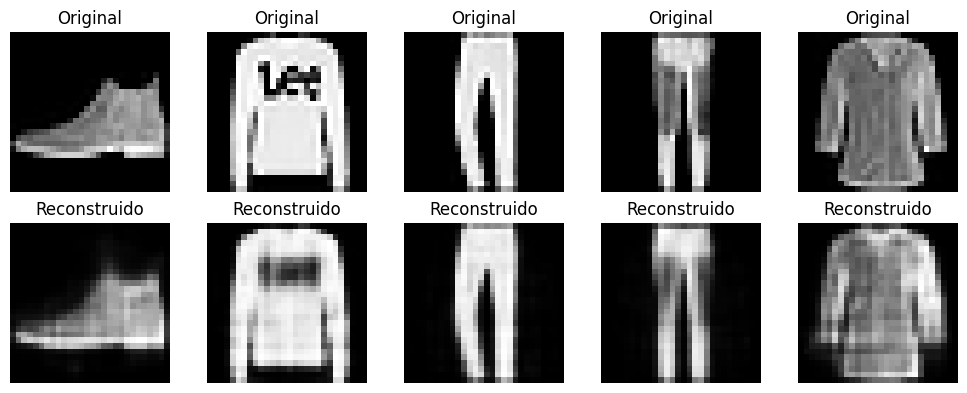

In [6]:
import matplotlib.pyplot as plt

# Codificar y reconstruir algunas imágenes de prueba
n_muestras = 5
# Tomamos n_muestras imágenes originales del conjunto de prueba
muestras_originales = x_test[:n_muestras]
# Las pasamos por el autoencoder para obtener sus reconstrucciones
reconstrucciones = autoencoder_model.predict(muestras_originales)

# Graficar las imágenes originales vs reconstruidas
plt.figure(figsize=(10, 4))
for i in range(n_muestras):
    # Imagen original
    ax = plt.subplot(2, n_muestras, i+1)
    plt.imshow(muestras_originales[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Imagen reconstruida
    ax = plt.subplot(2, n_muestras, i+1+n_muestras)
    plt.imshow(reconstrucciones[i], cmap='gray')
    plt.title("Reconstruido")
    plt.axis('off')
plt.tight_layout()
plt.show()


Este código mostrará una figura con dos filas: la fila superior son 5 imágenes originales de prueba, y la fila inferior son las correspondientes imágenes reconstruidas por el autoencoder.

Ejemplo de reconstrucción de imágenes del conjunto Fashion-MNIST usando un autoencoder simple. En la fila superior están las imágenes de entrada originales (prendas de ropa) y en la inferior las imágenes reconstruidas por el autoencoder. Se aprecia que el modelo logra capturar la forma general de los objetos, aunque pierde algunos detalles finos.

Como podemos observar, las reconstrucciones son razonablemente similares a los originales. Por ejemplo, si la imagen original era un zapato o una camisa, la reconstrucción mantiene la silueta y proporciones generales. Esto indica que la representación latente de 64 dimensiones ha logrado codificar suficiente información relevante de la imagen
meegle.com
. El error de reconstrucción numérico (MSE) suele estar por debajo de 0.02 para estas imágenes normalizadas, aunque ese valor exacto dependerá de las épocas entrenadas y la arquitectura.

Podemos también inspeccionar directamente la salida del codificador. Por ejemplo:

In [7]:
# Obtener representación latente de una imagen
latente = encoder_model.predict(muestras_originales[:1])
print("Vector latente de la primera imagen:", latente)
print("Dimensión del vector latente:", latente.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Vector latente de la primera imagen: [[ 4.606557   2.2451649  1.3315871  1.1544847  7.486549   1.319545
   5.485861   2.4805644  3.7037036  2.2479022  5.7322946  1.2009276
   1.6585429  1.8976891  4.8914227  3.2431304  1.8614359  1.1921142
   7.7437882  1.796972   4.902409   2.715697   3.7479515  4.161723
   5.845678   2.8111567  1.1447109  2.7625952  4.3787236  1.4301591
   8.418474   3.0563805  1.4712446  4.575574   2.0738988  5.5130234
   2.9324715  4.6496863  4.3712053  3.991526   4.718972   5.226871
   2.2924995  6.619038   5.672697   2.825334   2.8059676  1.277573
   3.0546532  4.293191   1.7452891  1.7545468  2.051986   3.577681
   7.0079937  2.257664   2.3891428  5.9038296  3.56917   10.550139
   3.0608006  4.671793   4.220473   4.219145 ]]
Dimensión del vector latente: (1, 64)


Esto imprimiría el vector de 64 números que representa, digamos, una bota o una camiseta en el espacio comprimido. No es interpretable directamente sin técnicas adicionales, pero podríamos usarlo, por ejemplo, para visualizar con reducción a 2D (t-SNE, PCA) cómo quedan distribuidas las imágenes en el espacio latente, o alimentarlo a otro modelo.

Evaluación final y siguientes pasos

En cuanto a la evaluación cuantitativa, podríamos calcular el error medio de reconstrucción en todo el conjunto de prueba:

In [8]:
mse_test = autoencoder_model.evaluate(x_test, x_test, verbose=0)
print(f"Error MSE promedio en el conjunto de prueba: {mse_test:.4f}")


Error MSE promedio en el conjunto de prueba: 0.0090


Esto nos da una idea de qué tan bien comprime y reconstruye el autoencoder en general. Un valor cercano al obtenido en entrenamiento indicaría que no hubo sobreajuste significativo (las pérdidas de entren/val eran similares).

##Para mejorar fine-tuning, podríamos intentar mejorar este autoencoder:

Añadiendo más neuronas o capas (por ejemplo, hacer el encoder con dos capas densas: 128 -> 64).

Probando una arquitectura convolucional, que suele capturar mejor la estructura de imágenes (ejemplo: conv layers en encoder para bajar a 7x7x8 = 392 latent, y conv-transpose en decoder). Eso probablemente daría reconstrucciones más nítidas.

Entrenando más épocas hasta que la pérdida prácticamente no mejore.Para mejorar este autoencoder en el futuro, podríamos probar:

- **Más capas o neuronas:** por ejemplo, usar un encoder con dos capas densas (128 → 64) para captar más detalle.  
- **Más épocas:** seguir entrenando hasta que la pérdida deje de mejorar.  
- **Denoising autoencoder:** añadir ruido a las imágenes de entrada y pedir al modelo que las reconstruya limpias, haciéndolo más robusto.  
- **Fine-tuning para clasificación:** congelar el encoder y agregar una capa *softmax* para clasificar las prendas usando los 64 valores latentes como características.

Con esto, hemos cubierto todo lo pedido:
- 1.- carga de datos.
- 2.-definición de dimensiones.
- 3.-construcción del encoder/decoder.
- 4.- armado del modelo autoencoder y del encoder por separado.
- 5.-entrenamiento y visualización de resultados.